In [10]:
import pandas as pd
import numpy as np
#from movienet import MovieNet

In [2]:
#from autoencoder import *

In [3]:
with open(f'tfidf_matrix.pkl', 'rb') as fh:
    tfidf = pickle.load(fh)

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [4]:
#ratings=pd.read_csv('ratings1.csv')
ratings=pd.read_csv('ratings1.dat', sep='::', header=None, engine='python', encoding='latin-1')

In [5]:
ratings.columns=['userId','movieId', 'rating', 'timestamp']

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [7]:
ratings.shape

(10000054, 4)

In [8]:
print(f"full dataset:\nnumber users {int(ratings.userId.nunique())}, number movies {int(ratings.movieId.nunique())}")

full dataset:
number users 69878, number movies 10677


In [9]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [10]:
n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())
n_factors = 100
print(f"number users: {n_users}, number movies {n_movies}")

number users: 69878, number movies 10677


In [11]:
#min_rating,max_rating = ratings.rating.min(),ratings.rating.max()


In [12]:
# x = ratings.drop(['rating', 'timestamp'],axis=1)
# y = ratings['rating'].astype(np.float32)

In [13]:
#x.head()

In [14]:
#y.head()

In [15]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [16]:
ratings_final=ratings.drop(['timestamp'],axis=1)
ratings_final=ratings_final.astype({"rating": np.float32})
ratings_final.head()

,userId,movieId,rating
0,0,0,5.0
1,0,1,5.0
2,0,2,5.0
3,0,3,5.0
4,0,4,5.0


In [17]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    matrix = np.zeros((num_users, num_items),dtype='float32')
    for (_, userID, itemID, rating) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [18]:
new_data=dataPreprocessor(ratings_final, n_users,n_movies)

In [19]:
ratings_final=ratings_final.astype({"rating": np.float32})

In [20]:
new_data

array([[5., 5., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
new_df=pd.DataFrame(new_data)

In [22]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,10667,10668,10669,10670,10671,10672,10673,10674,10675,10676
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,3.0,5.0,5.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
new_df=new_df.transpose()

In [24]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,69868,69869,69870,69871,69872,69873,69874,69875,69876,69877
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,5.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,5.0,0.0,0.0,3.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,5.0,0.0,0.0,0.0,4.5,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0


In [25]:
new_df.to_pickle('new_df_matrix.pkl')

In [4]:
with open(f'new_df_matrix.pkl', 'rb') as fh:
    new_df = pickle.load(fh)

In [5]:
ae = AutoEncoder(new_df, validation_perc=0.1, lr=1e-3, intermediate_size=2000, encoded_size=100)
#ae = AutoEncoder(tfidf, validation_perc=0.05, lr=1e-3, intermediate_size=5000, encoded_size=100)


datal= <torch.utils.data.dataloader.DataLoader object at 0x7f65582f4d90>


In [6]:
ae.train_loop(epochs=100)

Epoch 1/5
i= 50
train loss: 0.31533483 | validation loss: 0.32790279
i= 100
train loss: 0.29060414 | validation loss: 0.31675267
i= 150
train loss: 0.34711674 | validation loss: 0.30342406
Epoch 2/5
i= 50
train loss: 0.28460607 | validation loss: 0.29833099
i= 100
train loss: 0.27354485 | validation loss: 0.28637746
i= 150
train loss: 0.25272042 | validation loss: 0.27871877
Epoch 3/5
i= 50
train loss: 0.3080444 | validation loss: 0.26546082
i= 100
train loss: 0.252058 | validation loss: 0.25940496
i= 150
train loss: 0.36840412 | validation loss: 0.25429341
Epoch 4/5
i= 50
train loss: 0.21030338 | validation loss: 0.25191289
i= 100
train loss: 0.29700267 | validation loss: 0.23341557
i= 150
train loss: 0.27211711 | validation loss: 0.23083213
Epoch 5/5
i= 50
train loss: 0.23966418 | validation loss: 0.23005028
i= 100
train loss: 0.19644442 | validation loss: 0.22073255
i= 150
train loss: 0.20634866 | validation loss: 0.21819027


In [7]:
ae.train_loop(epochs=145)

Epoch 1/145
i= 50
train loss: 0.21082558 | validation loss: 0.21595867
i= 100
train loss: 0.17547941 | validation loss: 0.20887233
i= 150
train loss: 0.23984087 | validation loss: 0.20642887
Epoch 2/145
i= 50
train loss: 0.19158444 | validation loss: 0.20432445
i= 100
train loss: 0.19663207 | validation loss: 0.19870204
i= 150
train loss: 0.18451618 | validation loss: 0.19773258
Epoch 3/145
i= 50
train loss: 0.20915669 | validation loss: 0.19586404
i= 100
train loss: 0.25280908 | validation loss: 0.19592924
i= 150
train loss: 0.42553648 | validation loss: 0.1879916
Epoch 4/145
i= 50
train loss: 0.1269905 | validation loss: 0.18401623
i= 100
train loss: 0.23024251 | validation loss: 0.18432909
i= 150
train loss: 0.29638201 | validation loss: 0.18092115
Epoch 5/145
i= 50
train loss: 0.20750853 | validation loss: 0.17980367
i= 100
train loss: 0.23356582 | validation loss: 0.17861532
i= 150
train loss: 0.24769107 | validation loss: 0.17450313
Epoch 6/145
i= 50
train loss: 0.16133972 | vali

In [8]:
#ae.train_loop(epochs=20)

In [9]:
#ae.train_loop(epochs=10)

In [31]:
#ae1 = AutoEncoder(new_df, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)
#ae1.train_loop(epochs=2)

In [14]:
#encoded

In [15]:
with open('autoencodercoll_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded, fh)

In [4]:
tags = pd.read_csv('tags.dat',sep='::', header=None, engine='python', encoding='latin-1')
tags.columns=['userId','movieId','tag','timestamp']
tags.head()

,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [3]:
tags = pd.read_csv('tags.dat',sep='::', header=None, engine='python', encoding='latin-1')
tags.columns=['userId','movieId','tag','timestamp']
tags.head()

,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [5]:
#tags = pd.read_csv('tags.dat',sep='::', header=None, engine='python', encoding='latin-1')
#tags.columns=['userId_x','movieId','tag','timestamp_x','userId_y','rating','timestamp_y']
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print("the tags data has {} shape".format(tags.shape))
ratings = pd.read_csv("ratings1.dat", sep='::', header=None, engine='python', encoding='latin-1')
ratings.columns=['userId','movieId', 'rating', 'timestamp']
ratings = ratings.drop_duplicates('movieId')
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

7601 unique movies in tags.csv
the tags data has (95580, 4) shape
10677 unique movies in ratings.csv


In [6]:
m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}

In [7]:
#map movie index for tags data
tags = pd.merge(tags, ratings, on="movieId", how="right")
tags.movieId = tags.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print(tags.shape)
tags.head()

10677 unique movies in tags.csv
(98630, 7)


,userId_x,movieId,tag,timestamp_x,userId_y,rating,timestamp_y
0,15.0,1926,excellent!,1.215185e+09,38,5.0,1162149051
1,146.0,1926,surreal,1.193705e+09,38,5.0,1162149051
2,1751.0,1926,Jeunet,1.137525e+09,38,5.0,1162149051
3,2456.0,1926,Paris,1.163102e+09,38,5.0,1162149051
4,2456.0,1926,romance,1.163102e+09,38,5.0,1162149051


In [8]:
#map movie index for movie data
movies = pd.read_csv("movies1.dat", sep='::', header=None, engine='python', encoding='latin-1')
movies.columns=['movieId','title','genres']
#movies.head()
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

movies = pd.merge(movies, ratings, on="movieId", how="inner")
movies.movieId = movies.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

movies.set_index('movieId', inplace=True)
movies['genres'] = movies['genres'].str.replace(pat="|", repl=" ")
movies['genres'] = movies['genres'].str.replace(pat="-", repl="")
movies.query('title == "Primer (2004)"')

10681 unique movies in movies.csv
10677 unique movies in ratings.csv
10677 unique movies in movies.csv


,title,genres,userId,rating,timestamp
movieId,,,,,
2976,Primer (2004),Drama Mystery SciFi Thriller,92,5.0,1162165737


In [9]:
#create documents from tags
tags.fillna("", inplace=True)
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags.reset_index(inplace=True)
movie_id = tags.movieId
print("There are {} unique movies".format(len(movie_id)))
tags.sample(10)

There are 10677 unique movies


,movieId,tag
6863,6863,{Richard Attenborough Candice Bergen Richard A...
2397,2397,{fishing}
755,755,{John Landis Africa immigrants Arsenio Hall Ed...
9982,9982,{fake documental}
3750,3750,{Subgenre: Heroic Bloodshed gun fu explosions}
10482,10482,{}
8586,8586,{70mm}
6703,6703,{Henry Fonda Lucille Ball}
5904,5904,{musical american revolution congress politica...
10518,10518,{Musical}


In [10]:
# add genres to document
tags = pd.merge(movies, tags, left_index=True, right_on='movieId', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
tags.head(3)

,title,genres,userId,rating,timestamp,movieId,tag,document
0,Boomerang (1992),Comedy Romance,1,5.0,838985046,0,{dating Nudity (Topless - Brief) Can't remember},{dating Nudity (Topless - Brief) Can't remembe...
1,"Net, The (1995)",Action Crime Thriller,1,5.0,838983525,1,{computers computers internet Irwin Winkler Sa...,{computers computers internet Irwin Winkler Sa...
2,Dumb & Dumber (1994),Comedy,1,5.0,838983392,2,{Jeff Daniels Jim Carrey stupid Jim Carrey Shi...,{Jeff Daniels Jim Carrey stupid Jim Carrey Shi...


In [11]:
tags[tags['title'].str.contains("Cinderella")]

,title,genres,userId,rating,timestamp,movieId,tag,document
1193,Ever After: A Cinderella Story (1998),Comedy Drama Fantasy Romance,14,4.0,1133576251,1193,{definitely for girls lovely xvgb funny chick ...,{definitely for girls lovely xvgb funny chick ...
1450,Cinderella (1950),Animation Children Fantasy Musical Romance,19,5.0,877086235,1450,{Disney Disney library vhs fairy tale Disney f...,{Disney Disney library vhs fairy tale Disney f...
2979,Cinderella Man (2005),Drama Romance,92,3.0,1162165478,2979,{crowe did it again boxing Nice drama not as g...,{crowe did it again boxing Nice drama not as g...
6589,"Cinderella Story, A (2004)",Comedy Romance,874,3.5,1162530606,6589,{Bibliothek based on a book Drama Hilary Duff ...,{Bibliothek based on a book Drama Hilary Duff ...
9272,Cinderella (1997),Children Fantasy Musical Romance,5405,4.0,1227152784,9272,{},{} Children Fantasy Musical Romance


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    ngram_range=(0, 1),
    min_df=0.0001,
    stop_words='english')
tfidf_matrix = tfidf.fit_transform(tags['document'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=tags.index.tolist())
print(tfidf_df.shape)
tfidf_df.head(3)

(10677, 6250)


,0,1,2,3,4,5,6,7,8,9,...,6240,6241,6242,6243,6244,6245,6246,6247,6248,6249
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
tfidf_df.to_pickle('tfidf_matrix.pkl')

In [21]:
ae1 = AutoEncoder(tfidf_df, validation_perc=0.1, lr=1e-3, intermediate_size=900, encoded_size=100)

datal= <torch.utils.data.dataloader.DataLoader object at 0x7f79f2c7be10>


In [22]:
ae1.train_loop(epochs=30)

Epoch 1/30
train loss: 0.2391832 | validation loss: 0.18588601)
train loss: 0.22586899 | validation loss: 0.18180402)
train loss: 0.21859425 | validation loss: 0.18887985)
train loss: 0.2167014 | validation loss: 0.20691377)
train loss: 0.21543203 | validation loss: 0.21924669)
train loss: 0.20605822 | validation loss: 0.2139274)
train loss: 0.20228587 | validation loss: 0.19938968)
Epoch 2/30
train loss: 0.19994999 | validation loss: 0.20324397)
train loss: 0.19207145 | validation loss: 0.20144577)
train loss: 0.18522128 | validation loss: 0.18006602)
train loss: 0.18550417 | validation loss: 0.17494939)
train loss: 0.17681316 | validation loss: 0.16451074)
train loss: 0.17498109 | validation loss: 0.16536534)
train loss: 0.17420757 | validation loss: 0.16593096)
Epoch 3/30
train loss: 0.17121659 | validation loss: 0.15960816)
train loss: 0.17385641 | validation loss: 0.15422997)
train loss: 0.15987308 | validation loss: 0.14988491)
train loss: 0.15478493 | validation loss: 0.1464826)

In [23]:
#ae1.train_loop(epochs=20)

In [24]:
#ae1.train_loop(epochs=20)

In [25]:
#ae1.train_loop(epochs=5)

In [26]:
losses1 = pd.DataFrame(data=list(zip(ae1.train_losses, ae1.val_losses)), columns=['train_loss', 'validation_loss'])
losses1['epoch'] = (losses1.index + 1) / 3

Text(0.5, 1.0, 'autoencoder loss over time')

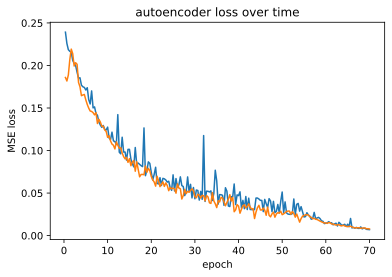

In [27]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses1['epoch'], losses1['train_loss'])
ax.plot(losses1['epoch'], losses1['validation_loss'])
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')

In [28]:
encoded1 = ae1.get_encoded_representations()

In [29]:
with open('autoencodercon_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded1, fh)

In [3]:
with open(f'tfidf_matrix.pkl', 'rb') as fh:
    tfidf_df1 = pickle.load(fh)

In [15]:
#ae2 = AutoEncoder(new_df1, validation_perc=0.1, lr=1e-3, intermediate_size=3000, encoded_size=100)
ae2 = AutoEncoder(tfidf_df1, validation_perc=0.1, lr=1e-3, intermediate_size=900, encoded_size=100)

In [16]:
ae2.train_loop(epochs=30)

Epoch 1/30
i= 20
train loss: 0.23530476 | validation loss: 0.18365635
i= 40
train loss: 0.22357292 | validation loss: 0.19156446
i= 60
train loss: 0.22732845 | validation loss: 0.19618365
i= 80
train loss: 0.21548831 | validation loss: 0.20167594
i= 100
train loss: 0.21266311 | validation loss: 0.21435273
i= 120
train loss: 0.20898134 | validation loss: 0.20511483
i= 140
train loss: 0.2040506 | validation loss: 0.20580655
Epoch 2/30
i= 20
train loss: 0.20361391 | validation loss: 0.19221185
i= 40
train loss: 0.19174379 | validation loss: 0.19801868
i= 60
train loss: 0.18998598 | validation loss: 0.18013354
i= 80
train loss: 0.19024231 | validation loss: 0.17321955
i= 100
train loss: 0.18127784 | validation loss: 0.1703154
i= 120
train loss: 0.17620385 | validation loss: 0.17059261
i= 140
train loss: 0.16991983 | validation loss: 0.17320888
Epoch 3/30
i= 20
train loss: 0.17265868 | validation loss: 0.15576218
i= 40
train loss: 0.16534144 | validation loss: 0.15535089
i= 60
train loss: 0

In [17]:
encoded2 = ae2.get_encoded_representations()

In [18]:
encoded2.shape

(10677, 100)

In [19]:
with open('autoencodercon2_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded2, fh)

In [20]:
losses2 = pd.DataFrame(data=list(zip(ae2.train_losses, ae2.val_losses)), columns=['train_loss', 'validation_loss'])
losses2['epoch'] = (losses2.index + 1) / 3

In [2]:
with open(f'new_df_matrix.pkl', 'rb') as fh:
    new_df1 = pickle.load(fh)

In [1]:
import pandas as pd
import numpy as np

import torch
import numpy as np
import pandas as pd
import pickle
import multiprocessing
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset

    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)]
        val_pct : (int, float), validation set percentage
        seed : seed value for RandomState

    Returns:
        list of indexes
    """
    np.random.seed(seed)
    n_val = int(val_pct * n)
    idx_start = cv_idx * n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start + n_val]


def split_by_idx(idxs, *a):
    """
    Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
    This can be used to split multiple arrays containing training data to validation and training set.

    :param idxs [int]: list of indexes selected
    :param a list: list of np.array, each array should have same amount of elements in the first dimension
    :return: list of tuples, each containing a split of corresponding array from *a.
            First element of each tuple is an array composed from elements selected by idxs,
            second element is an array of remaining elements.
    """
    mask = np.zeros(len(a[0]), dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask], o[~mask]) for o in a]


class AutoEncoder(object):

    def __init__(self, data, validation_perc=0.2, lr=0.001,
                 intermediate_size=1000, encoded_size=100):

        # create training dataloader and validation tensor
        self.data = data
        self.val_idxs = get_cv_idxs(n=data.shape[0], val_pct=validation_perc)
        [(self.val, self.train)] = split_by_idx(self.val_idxs, data)
        self.dataset = AETrainingData(self.train)
        self.dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True,
                                     num_workers=multiprocessing.cpu_count())
        #print('datal=',self.dataloader)
        self.val = torch.from_numpy(self.val.values).\
            type(torch.FloatTensor).cuda()

        # instantiate the encoder and decoder nets
        size = data.shape[1]
        self.encoder = Encoder(size, intermediate_size, encoded_size).cuda()
        self.decoder = Decoder(size, intermediate_size, encoded_size).cuda()

        # instantiate the optimizers
        self.encoder_optimizer = optim.Adam(
            self.encoder.parameters(), lr=lr, weight_decay=1e-8)
        self.decoder_optimizer = optim.Adam(
            self.decoder.parameters(), lr=lr, weight_decay=1e-8)

        # instantiate the loss criterion
        self.criterion = nn.MSELoss(reduction='mean')

        self.train_losses = []
        self.val_losses = []

    def train_step(self, input_tensor, target_tensor):
        # clear the gradients in the optimizers
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # Forward pass through
        encoded_representation = self.encoder(input_tensor)
        reconstruction = self.decoder(encoded_representation)

        # Compute the loss
        loss = self.criterion(reconstruction, target_tensor)

        # Compute the gradients
        loss.backward()

        # Step the optimizers to update the model weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # Return the loss value to track training progress
        return loss.item()
    
    def reset(self, train=True):
        # due to dropout the network behaves differently in training and
        # evaluation modes
        if train: self.encoder.train(); self.decoder.train()
        else: self.encoder.eval(); self.decoder.eval()

    def get_val_loss(self, input_tensor, target_tensor):
        self.reset(train=False)
        encoded = self.encoder(input_tensor)
        decoded = self.decoder(encoded)
        loss = self.criterion(decoded, target_tensor)
        return loss.item()

    def train_loop(self, epochs, print_every_n_batches=20):

        # Cycle through epochs
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')

            # Cycle through batches
            for i, batch in enumerate(self.dataloader):
                #print(i,batch)
                
                self.reset(train=True)

                input_tensor = batch['input'].cuda()
                target_tensor = batch['target'].cuda()

                loss = self.train_step(input_tensor, target_tensor)

                if i % print_every_n_batches == 0 and i != 0:
                    #print('i=',i)
                    val_loss = self.get_val_loss(self.val, self.val)
                    print(f'train loss: {round(loss, 8)} | ' +
                          f'validation loss: {round(val_loss, 8)}')
                    self.train_losses.append(loss)
                    self.val_losses.append(val_loss)

    def get_encoded_representations(self):
        to_encode = torch.from_numpy(self.data.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        encodings = self.encoder(to_encode).cpu().data.numpy()
        return encodings


class AETrainingData(Dataset):
    """
    Format the training dataset to be input into the auto encoder.
    Takes in dataframe and converts it to a PyTorch Tensor
    """

    def __init__(self, x_train):
        self.x = x_train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        """
        Returns a example from the data set as a pytorch tensor.
        """
        # Get example/target pair at idx as numpy arrays
        x, y = self.x.iloc[idx].values, self.x.iloc[idx].values

        # Convert to torch tensor
        x = torch.from_numpy(x).type(torch.FloatTensor)
        y = torch.from_numpy(y).type(torch.FloatTensor)

        # Return pair
        return {'input': x, 'target': y}


class Encoder(nn.Module):
    def __init__(self, input_size, intermediate_size, encoding_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, encoding_size),
            nn.BatchNorm1d(encoding_size),
            nn.ReLU(True),
            nn.Dropout(0.2))

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, output_size, intermediate_size, encoding_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        return x


In [2]:
with open(f'new_df_matrix.pkl', 'rb') as fh:
    new_df1 = pickle.load(fh)

In [3]:
ae3 = AutoEncoder(new_df1, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)

In [20]:
#ae3.train_loop(epochs=50)

In [21]:
#ae3.train_loop(epochs=30)

In [22]:
#ae3.train_loop(epochs=10)

In [ ]:
#ae3.train_loop(epochs=10)

In [11]:
losses2 = pd.DataFrame(data=list(zip(ae3.train_losses, ae3.val_losses)), columns=['train_loss', 'validation_loss'])
losses2['epoch'] = (losses2.index + 1) / 3

In [13]:
encoded3 = ae3.get_encoded_representations()

In [14]:
with open('autoencodercoll31_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded3, fh)

In [23]:
#ae_4 = AutoEncoder(new_df1, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)

In [24]:
#ae_4.train_loop(epochs=5)

In [25]:
#ae_4.train_loop(epochs=20)

In [3]:
ndf=new_df1

In [4]:
ndf=ndf.apply(lambda x: x/x.max(), axis=0)

In [5]:
ndf.head()

,0,1,2,3,4,5,6,7,8,9,...,69868,69869,69870,69871,69872,69873,69874,69875,69876,69877
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.6,0.0
2,1.0,0.0,0.0,0.2,0.0,0.0,0.0,0.6,0.0,0.0,...,0.0,0.0,0.2,0.0,0.4,0.0,0.6,0.0,0.0,0.0
3,1.0,0.0,0.0,0.6,0.0,0.0,0.0,0.7,0.0,0.0,...,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.9,0.0,0.0,...,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.6,0.8


In [6]:
# with open('ndf.pkl', 'wb') as fh:
#     pickle.dump(ndf, fh)

In [7]:
# with open(f'ndf.pkl', 'rb') as fh:
#     ndf1 = pickle.load(fh)

In [8]:
ae_4 = AutoEncoder(ndf, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)

In [9]:
ae_4.train_loop(epochs=50)

Epoch 1/50
train loss: 0.22579755 | validation loss: 0.24893086
train loss: 0.2182643 | validation loss: 0.21357031
train loss: 0.21496026 | validation loss: 0.20806929
train loss: 0.21106842 | validation loss: 0.20373096
train loss: 0.20224987 | validation loss: 0.19790372
train loss: 0.19804391 | validation loss: 0.19965415
train loss: 0.19187984 | validation loss: 0.18708843
Epoch 2/50
train loss: 0.1933123 | validation loss: 0.18844429
train loss: 0.19149779 | validation loss: 0.18113759
train loss: 0.17587638 | validation loss: 0.16672805
train loss: 0.17481491 | validation loss: 0.1630431
train loss: 0.17034365 | validation loss: 0.16115648
train loss: 0.16301687 | validation loss: 0.16274516
train loss: 0.18125041 | validation loss: 0.15972771
Epoch 3/50
train loss: 0.16036288 | validation loss: 0.15345499
train loss: 0.15580224 | validation loss: 0.1512844
train loss: 0.15296936 | validation loss: 0.14347586
train loss: 0.15924722 | validation loss: 0.14307053
train loss: 0.145

In [10]:
ae_4.train_loop(epochs=20)

Epoch 1/20
train loss: 0.00686787 | validation loss: 0.00756736
train loss: 0.00717324 | validation loss: 0.00737017
train loss: 0.01046933 | validation loss: 0.0072428
train loss: 0.00721075 | validation loss: 0.00744201
train loss: 0.00838955 | validation loss: 0.00727072
train loss: 0.00565965 | validation loss: 0.00749205
train loss: 0.00684001 | validation loss: 0.00707733
Epoch 2/20
train loss: 0.00559237 | validation loss: 0.00739102
train loss: 0.00613396 | validation loss: 0.00728957
train loss: 0.00593679 | validation loss: 0.00717643
train loss: 0.00574867 | validation loss: 0.00711014
train loss: 0.01034911 | validation loss: 0.0071165
train loss: 0.00511383 | validation loss: 0.00700862
train loss: 0.00742158 | validation loss: 0.00713419
Epoch 3/20
train loss: 0.00689163 | validation loss: 0.00726537
train loss: 0.00949097 | validation loss: 0.0069458
train loss: 0.00872581 | validation loss: 0.00688298
train loss: 0.00570961 | validation loss: 0.00692019
train loss: 0.00

In [13]:
ae_4.train_loop(epochs=20)

Epoch 1/50
train loss: 0.21489999 | validation loss: 0.21649054
train loss: 0.19971737 | validation loss: 0.19290787
train loss: 0.23356685 | validation loss: 0.18819165
Epoch 2/50
train loss: 0.18743429 | validation loss: 0.17428115
train loss: 0.17178538 | validation loss: 0.16203174
train loss: 0.2356452 | validation loss: 0.1503925
Epoch 3/50
train loss: 0.15602335 | validation loss: 0.14724115
train loss: 0.15021554 | validation loss: 0.14173602
train loss: 0.16970026 | validation loss: 0.12773024
Epoch 4/50
train loss: 0.14281948 | validation loss: 0.1233262
train loss: 0.12688211 | validation loss: 0.11928833
train loss: 0.20054783 | validation loss: 0.1079348
Epoch 5/50
train loss: 0.11612576 | validation loss: 0.10873526
train loss: 0.10732884 | validation loss: 0.10154027
train loss: 0.18133566 | validation loss: 0.0952955
Epoch 6/50
train loss: 0.09748188 | validation loss: 0.09069753
train loss: 0.09065448 | validation loss: 0.08849635
train loss: 0.13726079 | validation lo

In [15]:
ae_4.train_loop(epochs=10)

Epoch 1/10
train loss: 0.00669099 | validation loss: 0.00601894
train loss: 0.00469608 | validation loss: 0.00604354
train loss: 0.00656378 | validation loss: 0.00602584
train loss: 0.00787973 | validation loss: 0.0060766
train loss: 0.0059836 | validation loss: 0.00598687
train loss: 0.00387794 | validation loss: 0.00606507
train loss: 0.00521555 | validation loss: 0.00605975
Epoch 2/10
train loss: 0.00510335 | validation loss: 0.00604949
train loss: 0.00465114 | validation loss: 0.00600495
train loss: 0.00461911 | validation loss: 0.00608244
train loss: 0.00607927 | validation loss: 0.0060724
train loss: 0.00485418 | validation loss: 0.00600468
train loss: 0.00404608 | validation loss: 0.00609499
train loss: 0.00510981 | validation loss: 0.00602119
Epoch 3/10
train loss: 0.00427753 | validation loss: 0.00609052
train loss: 0.00566976 | validation loss: 0.00602321
train loss: 0.00624995 | validation loss: 0.00608642
train loss: 0.00634583 | validation loss: 0.00598345
train loss: 0.00

In [26]:
#ae_4.train_loop(epochs=145)

In [8]:
losses3 = pd.DataFrame(data=list(zip(ae_4.train_losses, ae_4.val_losses)), columns=['train_loss', 'validation_loss'])
losses3['epoch'] = (losses3.index + 1) / 3

In [16]:
losses3 = pd.DataFrame(data=list(zip(ae_4.train_losses, ae_4.val_losses)), columns=['train_loss', 'validation_loss'])
losses3['epoch'] = (losses3.index + 1) / 3

Text(0.5, 1.0, 'autoencoder loss over time')

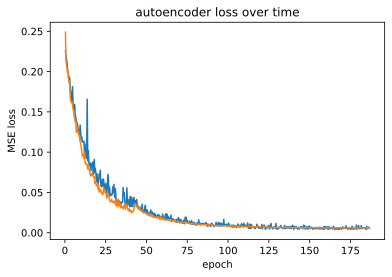

In [17]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses3['epoch'], losses3['train_loss'])
ax.plot(losses3['epoch'], losses3['validation_loss'])
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')

Text(0.5, 1.0, 'autoencoder loss over time')

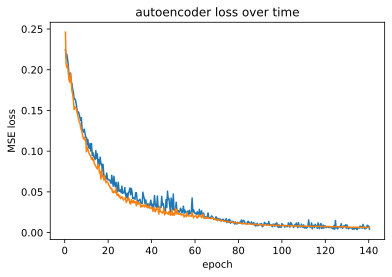

In [9]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses3['epoch'], losses3['train_loss'])
ax.plot(losses3['epoch'], losses3['validation_loss'])
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')

In [18]:
encoded4 = ae_4.get_encoded_representations()

In [19]:
with open('autoencodercoll42_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded4, fh)